In [1]:
import multipers as mp
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

This notebook will showcase how to use the multipers library core functions. As it relies on gudhi code, the syntax is almost the same.

The example we provide can be tweaked in different ways; don't hesitate to read the functions documentations to figure out how to do so.

In [2]:
st = mp.SimplexTreeMulti(num_parameters=2)
st.insert([0],[0,1])
st.insert([1],[1,0])
st.insert([0,1],[1,1])
list(st.get_simplices()) # list of (simplex, filtration)

[([0, 1], [1.0, 1.0]), ([0], [0.0, 1.0]), ([1], [1.0, 0.0])]

Furthermore, gudhi simplextrees can be converted to simplextreemulti's easily. 

In [3]:
st2 = gd.RipsComplex(points=[[0,1], [1,0], [0,0]]).create_simplex_tree()
st2 = mp.SimplexTreeMulti(st2, num_parameters=3) # the gudhi filtration is placed on axis 0
list(st2.get_simplices())

[([0, 1], [1.4142135381698608, -inf, -inf]),
 ([0, 2], [1.0, -inf, -inf]),
 ([0], [0.0, -inf, -inf]),
 ([1, 2], [1.0, -inf, -inf]),
 ([1], [0.0, -inf, -inf]),
 ([2], [0.0, -inf, -inf])]

Almost all methods of gudhi simplextree should work ootb on simplextreemultis, and some are reimplemented, e.g., make_filtration_non_decreasing, expand, edge_collapse. 

Furthermore, some methods are removed, e.g., persistence, and are replaced by other topological invariants. For instance interval approximations, provided by `MMA` (wich comes itself with its own `PyModule` structure), or signed measures derived from the dimension vector of the module or the Euler characteristic.

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


([[0.0, 1.0], [1.0, 0.0]], [[inf, inf]])

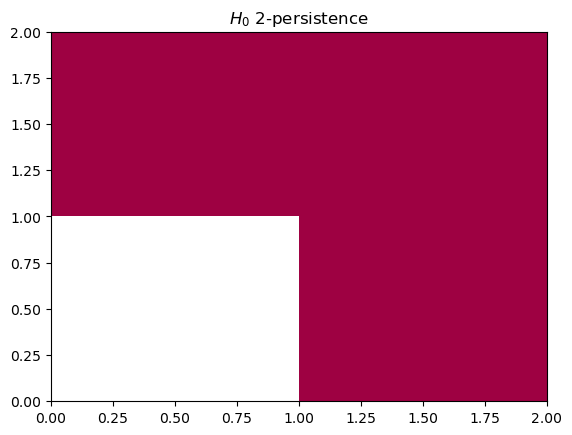

In [4]:
mma_pymodule = st.persistence_approximation()
mma_pymodule.plot(degree=0, box=[[0,0],[2,2]])
mma_pymodule[0].get_birth_list(), mma_pymodule[0].get_death_list()

The signed measure obtained by the degree 0 homology can be retrieved using

In [5]:
mp.signed_measure(st, degree=0, zero_pad=False)

(array([[0, 1],
        [1, 0],
        [1, 1]]),
 array([ 1,  1, -1]))

And the signed measure obtained via the euler characteristic (`degree=None`) 

In [6]:
mp.signed_measure(st, zero_pad=False)

(array([[0, 1],
        [1, 0],
        [1, 1]]),
 array([ 1,  1, -1]))

For filtration that are not over $\mathbb N^n$, it is necessary (for the moment) to convert filtration values of a simplextree to coordinate on a grid (which is over $\mathbb N^n$). An example is shown below.

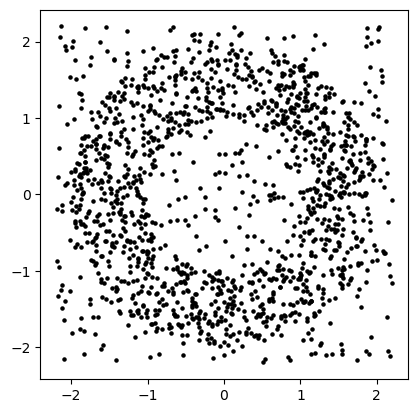

In [7]:
# Dataset
X = mp.noisy_annulus(n1=1000, n2=500) # 1000 points on the annulus, 500 points on the square.
plt.scatter(X[:,0], X[:,1], s=5, c='k');plt.gca().set_aspect(1);
# Gudhi SimplexTree
st = gd.RipsComplex(points=X, max_edge_length=2.1).create_simplex_tree()
# SimplexTreeMulti, with 2 parameters
st = mp.SimplexTreeMulti(st, num_parameters=2)

`st` is now a SimplexTreeMulti, whose first parameter is a rips, and the second parameter is undefined.

Let's fill the second parameter.

In [8]:
from sklearn.neighbors import KernelDensity
codensity = - KernelDensity(bandwidth=0.5, atol=0.1, rtol=0.1).fit(X).score_samples(X) # We don't need perfectly exact values, so atol and rtol can be used
# parameter = 1 is the second parameter as python starts with 0.
st.fill_lowerstar(codensity, parameter=1) # This fills the second parameter with the co-log-density

Let us now convert this simplextree to a coordinate simplextree.

We first need a **filtration grid**, which can be retrieved with the `get_filtration_grid` method.

We will do exact computation here, but notice that this method has different strategy to approximate a grid; which can make computation significantly faster !

In [9]:
F = st.get_filtration_grid(grid_strategy="exact")
[len(f) for f in F]

[531810, 1499]

**Remark :** A rips complex contains **a lot** of unnecessary edges, which can make the filtration grid prohibitly large; we will simplificate the simplextree, before computing this exact grid. This can be done using the `collapse_edges` method, which relies on [filtration_domination](https://github.com/aj-alonso/filtration_domination).

In [10]:
st.collapse_edges(full=True, progress=True) # This should take less than 20s

Removing edges:  21%|██        | 21/100 [00:09<00:37,  2.10it/s]


In [11]:
F = st.get_filtration_grid(grid_strategy="exact")
[len(f) for f in F]

[6046, 1499]

To get an idea of the shape of the module, we can compute first an approximation of it, using `MMA`.

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


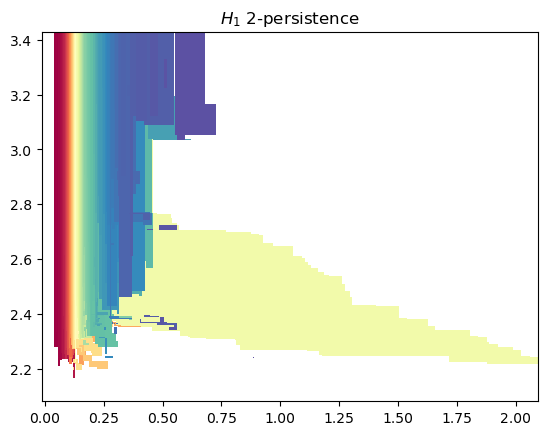

In [12]:
st.expansion(2) # Be careful, we have to expand the dimension to 2 before computing degree 1 homology.
st.persistence_approximation().plot(degree=1) # Should take less than ~10 seconds depending on the seed

We now turn `st` into a coordinate simplextree w.r.t. $F$, using the `grid_squeeze` method.

In [13]:
st_coord = mp.SimplexTreeMulti(st) # We do a copy first (for later use), as this changes the filtration values.
st_coord.grid_squeeze(F,coordinate_values=True)

In [14]:
list(st_coord.get_simplices())[:3] # filtration values are now integers 

[([0, 327, 418], [2930.0, 248.0]),
 ([0, 327, 429], [3096.0, 11.0]),
 ([0, 327, 958], [2062.0, 19.0])]

We can now compute the signed measure of degree 1 of this complex.

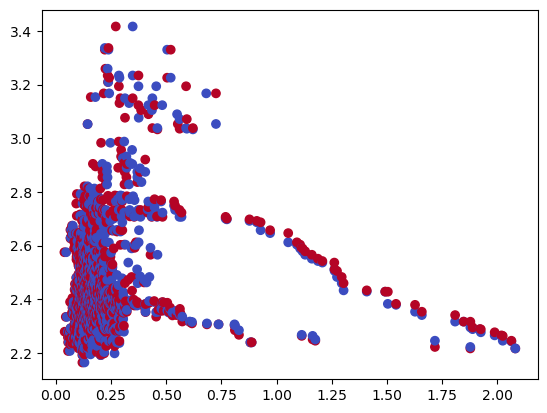

In [15]:
# The zero pad zeros out the grid, should take less than ~10s
sm_hilbert = mp.signed_measure(st_coord,degree=1, plot=True, zero_pad=False) 

Note that the Euler signed measure **cannot** be computed here (unless you have a **lot** of RAM), as one would need to do a `st.expansion(#num_verticies)` beforehand.

This is why we **need to simplificate** the originial simplextree, by using a grid of lower resolution. 

In [16]:
F = st.get_filtration_grid(resolution=200, grid_strategy="regular")
[len(f) for f in F]

[200, 200]

In [17]:
st_coord = mp.SimplexTreeMulti(st)
st_coord.grid_squeeze(F, coordinate_values=True)
st_coord.collapse_edges(full=True, progress=True, ignore_warning=True)
st_coord.expansion(st_coord.num_vertices())
st_coord.num_simplices() ## This is way less than before !

Removing edges:  11%|█         | 11/100 [00:00<00:03, 25.08it/s]


29269

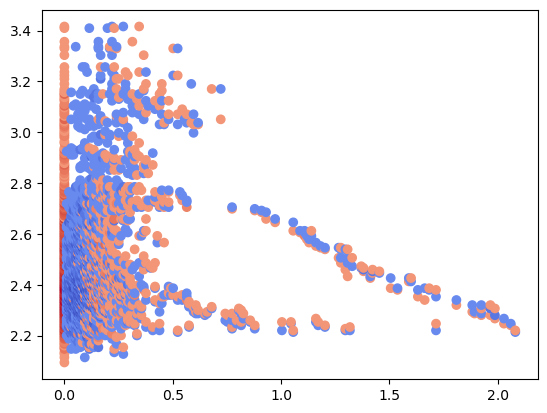

In [18]:
# should be instantaneous
sm_euler = mp.signed_measure(st_coord,degree=None,plot=True, zero_pad=False)

For the slicedwasserstein distances, and the convolutions of the signed measures, we recommend to use the already provided pipelines :
 - `multipers.ml.multi.SignedMeasure2Convolution`
 - `multipers.ml.multi.SignedMeasure2SlicedWassersteinDistance`

Note that the second one **needs** signed measures of null mass. So set the `zero_pad` flag to `True` when using these pipelines.

In [19]:
from multipers.ml.multi import SignedMeasure2Convolution, SignedMeasure2SlicedWassersteinDistance

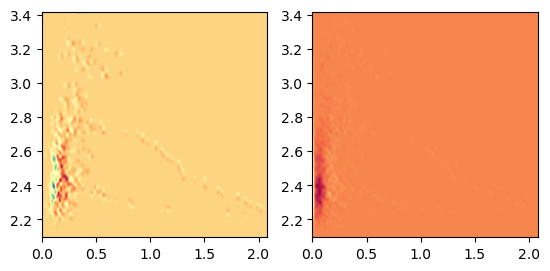

In [20]:
img_hilbert, img_euler = SignedMeasure2Convolution(resolution=200, plot=True,bandwidth=0.01).fit_transform([[sm_hilbert], [sm_euler]])